In [1]:
import pandas as pd
import numpy as np
import time
import re
import csv

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import (KFold, RandomizedSearchCV, 
                                     GridSearchCV, train_test_split)
from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

shape bd =  26070
mean  1070.135481396241
meadian  449.0
max  166928


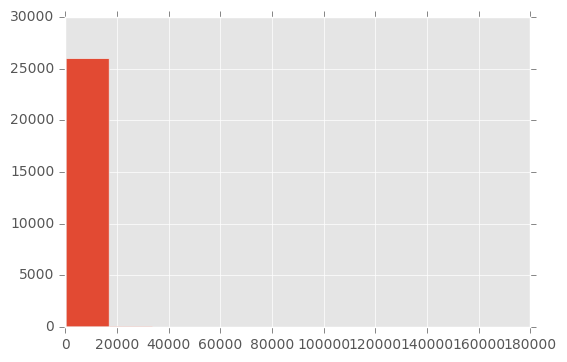

In [2]:
work_data = pd.read_csv('work_data.csv')
data_shape_init = work_data.shape[0]
# low = work_data.likes.quantile(0.25)
# up = work_data.likes.quantile(0.75)
# board = round(1.5*(up - low))
board = work_data.likes.quantile(0.95)
# print('1.5_IQR', board)
bd = work_data[work_data['likes'] >= board]
# bd['likes'].hist()
print('shape bd = ', bd.shape[0])
print('mean ', bd['likes'].mean())
print('meadian ', bd['likes'].median())
print('max ', bd['likes'].max())

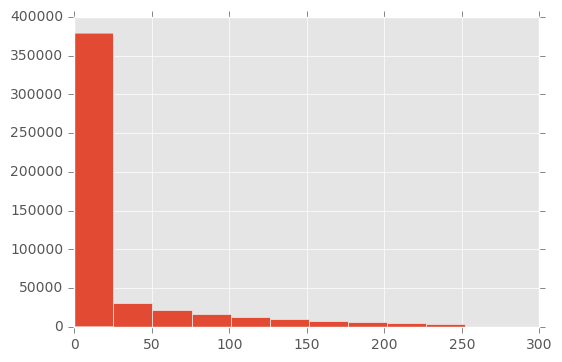

In [3]:
# print(np.unique(bd[bd['likes'] >= 20000]['group_id']))
# print(bd[bd['likes'] < 200000]['likes'].mean())
# print(len(np.unique(bd[bd['likes'] >= 20000]['group_id'])))
# # print(np.unique(bd[bd['likes'] >= 10000]['post_id']))
# print(len(np.unique(bd[bd['likes'] >= 5000]['post_id'])))
# print(work_data[(work_data['group_id'] == 3584) 
#                 & (work_data['likes'] <= 256)]['likes'].mean())
# # print(bd['timestamp'].mean())
# # print(work_data[work_data['post_id'] != any(bd['post_id'])]['timestamp'].mean())
# # likable_data = bd
# # likable_data['likable'] = 1
work_data = work_data[work_data['likes'] < work_data.likes.quantile(0.95)]
work_data['likes'].hist()

In [4]:
print('Data shape init: ', data_shape_init)
print('Data shape now: ', work_data.shape[0])
wd = work_data
n_posts = np.unique(work_data.post_id).shape[0]
print('N posts = ', n_posts)
likes_mean = wd.likes.mean()
print('Likes per Post mean = ', likes_mean)
likes_median = wd.likes.median()
print('Likes per Post median = ', likes_median)
likes_std = wd.likes.std()
print('Likes per Post std = ', likes_std)
# wd[wd.likes > wd.likes.quantile(0.9)].shape[0]
# wd[~(np.abs(wd.Data-wd.Data.mean())>(3*wd.Data.std()))]

Data shape init:  519869
Data shape now:  493799
N posts =  493799
Likes per Post mean =  25.02018230089571
Likes per Post median =  1.0
Likes per Post std =  49.562469872758946


In [5]:
from math import isnan

groups = np.unique(wd['group_id'])
# print('N groups: ', groups.shape[0])

stats = pd.DataFrame()
stats['group_id'] = groups
stats['group_birth'] = 0
stats['group_lbirth'] = 0
stats['group_mean'] = 0
stats['group_posts_number'] = 0

for group_id in groups:
    group_likes = wd[wd['group_id'] == group_id]['likes']
    group_posts_number = len(wd[wd['group_id'] == group_id])
    group_birth = wd[wd['group_id'] == group_id]['timestamp'].min()
    group_likes_birth = wd[(wd['group_id'] == group_id) & 
                           (wd['likes'] > 0)]['timestamp'].min()
    if isnan(group_likes_birth):
        group_likes_birth = 0
    group_mean = wd[(wd['group_id'] == group_id)]['likes'].mean()
    
    # print('group_likes_sum = ', group_likes.sum())
    # print('group_size = ', group_posts_number)
    # print('group_birth = ', group_birth)
    # print('group_lbirth = ', group_likes_birth)
    # print('group_mean = ', group_mean)

    stats.loc[stats['group_id'] == group_id, 'group_posts_number'] = group_posts_number
    stats.loc[stats['group_id'] == group_id, 'group_birth'] = group_birth
    stats.loc[stats['group_id'] == group_id, 'group_lbirth'] = group_likes_birth
    stats.loc[stats['group_id'] == group_id, 'group_mean'] = group_mean

In [6]:
def fix_input_content_file():
    with open('test_content.csv', 'r') as infile, open("new_test_content.csv", "w") as outfile:
        writer = csv.writer(outfile)
        for line in infile.readlines():
            line = line[:-2].split('\t')
            writer.writerow(line)

# fix need once
# fix_input_content_file()

test_content = pd.read_csv('new_test_content.csv', header=None)
test_content.columns = ['group_id', 'post_id', 'timestamp', 'content']
test_content['post_id'] = test_content['post_id'].interpolate().astype(int)
test_content['timestamp'] = test_content['timestamp'].interpolate().astype(int)

/home/mart/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
train_data = pd.merge(wd, stats, on='group_id', how='inner')
test_data = pd.merge(test_content, stats, on='group_id', how='inner')
y_train = train_data['likes']

In [8]:
def _add_time_features(df, timestamp):
    lt = lambda t: time.localtime(t / 1000)
    
    df['time_year'] = timestamp.apply(lambda t: int(lt(t).tm_year))
    df['time_wday'] = timestamp.apply(lambda t: int(lt(t).tm_wday))
    df['time_hour'] = timestamp.apply(lambda t: int(lt(t).tm_hour))

    df['time_work'] = timestamp.apply(lambda t: int(lt(t).tm_hour in range(10, 20)))
    df['time_active'] = timestamp.apply(lambda t: int(lt(t).tm_hour in range(20, 24)))
    df['time_night'] = timestamp.apply(lambda t: int(lt(t).tm_hour in range(0, 10)))
    
    day_ini = time.mktime(time.strptime("01 12 12", "%d %m %y"))*1000
    df['time_days'] = (timestamp - day_ini) / 86400000
    
    return df

In [9]:
def _add_content_features(df, content):
    ignore_count = lambda pattern: (lambda text: 
                                    len(re.findall(pattern, text, 
                                                   re.UNICODE | re.IGNORECASE)))
    count = lambda pattern: lambda text: len(re.findall(pattern, text, re.UNICODE))
    it_has = lambda pattern: (lambda text: 
                              int(len(re.findall(pattern, text, 
                                                 re.UNICODE | re.IGNORECASE)) > 0))

    df['number_chars'] = content.apply(lambda text: len(text))
    df['number_words'] = content.apply(lambda text: len(text.split(' ')))
    df['avg_word'] = df['number_chars'] / df['number_words']
    
    df['p_caps'] = content.apply(count(r'[А-ЯA-Z]')) / df['number_chars']
    df['p_rus'] = content.apply(count(r'[а-яА-Я]')) / df['number_chars']
    df['p_eng'] = content.apply(count(r'[a-zA-Z]')) / df['number_chars']
    
    df['number_images'] = content.apply(ignore_count(r'Images'))
    df['number_pools'] = content.apply(ignore_count(r'Pool\['))
    df['number_digits'] = content.apply(ignore_count(r'[0-9]'))
    df['number_quest'] = content.apply(count(r'\?'))
    df['number_signs'] = content.apply(count(r'\!'))
    df['number_quotes'] = content.apply(count(r'\"'))
    df['number_braces'] = content.apply(count(r'\(|\)'))
    df['number_3dots'] = content.apply(count(r'\.\.\.'))
    
    df['word_url'] = content.apply(it_has(r'http|\.net|\.ru|\.org|\.com'))
    df['word_pic'] = content.apply(it_has(r'\.jpg|\.jpeg|\.png|\.gif'))
    df['word_ok'] = content.apply(it_has(r'odnoklassniki|ok.ru'))
    df['word_male'] = content.apply(it_has(r'муж'))
    df['word_female'] = content.apply(it_has(r'жен'))
    df['word_love'] = content.apply(it_has(r'любов|любв'))
    df['word_friend'] = content.apply(it_has(r'друг'))
    df['word_happy'] = content.apply(it_has(r'счасть'))
    df['word_sad'] = content.apply(it_has(r'груст'))
    df['word_tears'] = content.apply(it_has(r'слез'))
    df['word_sad'] = content.apply(it_has(r'обид'))
    df['word_house'] = content.apply(it_has(r'дом'))
    df['word_road'] = content.apply(it_has(r'дорог'))
    df['word_soul'] = content.apply(it_has(r'душ'))
    df['word_faith'] = content.apply(it_has(r'вера|веру|вере'))
    df['word_god'] = content.apply(it_has(r'бог|боже'))
    df['word_say'] = content.apply(it_has(r'говор'))
    df['word_cinema'] = content.apply(it_has(r'фильм|кино'))
    df['word_memory'] = content.apply(it_has(r'помн'))
    df['word_like'] = content.apply(it_has(r'клас'))
    df['word_sell'] = content.apply(it_has(r'прод'))
    df['word_long'] = content.apply(it_has(r'—'))
    df['word_think'] = content.apply(it_has(r'дум'))
    df['word_ring'] = content.apply(it_has(r'звон'))
    df['word_child1'] = content.apply(it_has(r'дет'))
    df['word_cute'] = content.apply(it_has(r'милы|мило'))
    df['word_nobody'] = content.apply(it_has(r'никто'))
    
    return df

In [10]:
def extract(data):
    new_df = pd.DataFrame()
    
    # # Group features
    timestamp = data['timestamp']
    new_df['group_age'] = (timestamp - data['group_birth']) / 86400000
    new_df['group_lage'] = (timestamp - data['group_lbirth']) / 86400000
    new_df['group_mean'] = data['group_mean']
    new_df['group_size'] = data['group_posts_number']
    
    new_df = _add_time_features(new_df, timestamp)
    
    content = data['content']
    df = _add_content_features(new_df, content)
    
    return df

print('ok')

ok


In [11]:
X_train = extract(train_data)
print(X_train.head())

     group_age   group_lage  group_mean  group_size  time_year  time_wday  \
0    74.714288 -1610.380333    2.358974          78       2008          4   
1  1837.025469   151.930847    2.358974          78       2013          2   
2   735.166793  -949.927829    2.358974          78       2010          0   
3    96.851869 -1588.242753    2.358974          78       2008          5   
4   298.718670 -1386.375952    2.358974          78       2009          4   

   time_hour  time_work  time_active  time_night     ...       word_cinema  \
0         14          1            0           0     ...                 0   
1         22          0            1           0     ...                 0   
2          1          0            0           1     ...                 0   
3         17          1            0           0     ...                 0   
4         13          1            0           0     ...                 0   

   word_memory  word_like  word_sell  word_long  word_think  word_ri

In [12]:
def R2(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    print('R2: %2.3f' % r2)
    return r2


def my_r2_scorer():
    return make_scorer(R2, greater_is_better=True)

In [15]:
# params = {
#     'n_estimators': 40,
#     # 'min_samples_split': 5,
#     # 'min_samples_leaf': 7,
#     'n_jobs': -1,
#     'random_state': 241,
#     'verbose': 2,
#     'bootstrap': True,
#     'oob_score': True
# }

model = ExtraTreesRegressor(n_estimators=200, bootstrap=True, verbose=1, 
                            n_jobs=-1)

param_dist = {
    # "max_features": ['auto', 'sqrt', 'log2'],
    "max_features": ['auto'],
    "min_samples_split": sp_randint(2, 11),
    # "min_samples_split": [3, 8],
    "min_samples_leaf": sp_randint(2, 11),
    # "min_samples_leaf": [7, 10],
    'oob_score': [True]
}

cv = KFold(n_splits=3, shuffle=True, random_state=241)

randCV = RandomizedSearchCV(
    estimator=model,
    n_iter=10,
    param_distributions=param_dist,
    # param_grid=param_dist,
    scoring=my_r2_scorer(),
    cv=cv,
    verbose=2,
    n_jobs=-1
)

X_tr, x_t, y_tr, y_t = train_test_split(X_train, y_train, 
                                        test_size=0.66, 
                                        random_state=142)
print(X_tr.shape)

(167891, 51)


In [16]:
randCV.fit(X_tr, y_tr)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] max_features=auto, min_samples_split=8, min_samples_leaf=2, oob_score=True 


[CV] max_features=auto, min_samples_split=8, min_samples_leaf=2, oob_score=True 


[CV] max_features=auto, min_samples_split=8, min_samples_leaf=2, oob_score=True 


[CV] max_features=auto, min_samples_split=3, min_samples_leaf=2, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.5min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.6min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.6min finished


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.7min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.7min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.2s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.3s finished


R2: 0.694


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.9s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.0s finished


R2: 0.698


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.7s finished


R2: 0.698


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.6s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.9s finished


R2: 0.874


[CV]  max_features=auto, min_samples_split=8, min_samples_leaf=2, oob_score=True, total= 5.8min


[CV] max_features=auto, min_samples_split=3, min_samples_leaf=2, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.6s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.8s finished


R2: 0.873


[CV]  max_features=auto, min_samples_split=8, min_samples_leaf=2, oob_score=True, total= 5.9min


[CV] max_features=auto, min_samples_split=3, min_samples_leaf=2, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.2s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.6s finished


R2: 0.874


[CV]  max_features=auto, min_samples_split=8, min_samples_leaf=2, oob_score=True, total= 6.0min


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.4s


[CV] max_features=auto, min_samples_split=5, min_samples_leaf=3, oob_score=True 


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.6s finished


R2: 0.698


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   11.9s finished


R2: 0.914


[CV]  max_features=auto, min_samples_split=3, min_samples_leaf=2, oob_score=True, total= 6.1min


[CV] max_features=auto, min_samples_split=5, min_samples_leaf=3, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.4min finished


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.7min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.8min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.8min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.5min finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.6s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.7s finished


R2: 0.698


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.1s finished


R2: 0.867


[CV]  max_features=auto, min_samples_split=5, min_samples_leaf=3, oob_score=True, total= 5.8min


[CV] max_features=auto, min_samples_split=5, min_samples_leaf=3, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.9s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.0s finished


R2: 0.694


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.8s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.9s finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s


R2: 0.697


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.3s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.5s finished


R2: 0.698


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.6s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   11.0s finished


R2: 0.915


[CV]  max_features=auto, min_samples_split=3, min_samples_leaf=2, oob_score=True, total= 6.1min


[CV] max_features=auto, min_samples_split=10, min_samples_leaf=7, oob_score=True 


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   11.4s finished


R2: 0.914


[CV]  max_features=auto, min_samples_split=3, min_samples_leaf=2, oob_score=True, total= 6.1min


[CV] max_features=auto, min_samples_split=10, min_samples_leaf=7, oob_score=True 


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.2s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.7s finished


R2: 0.868


[CV]  max_features=auto, min_samples_split=5, min_samples_leaf=3, oob_score=True, total= 5.9min


[CV] max_features=auto, min_samples_split=10, min_samples_leaf=7, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.1min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.5min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.2min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.4min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.4min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.3min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.7min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.6s finished


R2: 0.697


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.7s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.9s finished


R2: 0.692


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.4s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.5s finished


R2: 0.696


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.9s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.1s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.2s finished


R2: 0.694


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.6s finished


R2: 0.779


[CV]  max_features=auto, min_samples_split=10, min_samples_leaf=7, oob_score=True, total= 5.7min


[CV] max_features=auto, min_samples_split=9, min_samples_leaf=9, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.8s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.0s finished


R2: 0.781


[CV]  max_features=auto, min_samples_split=10, min_samples_leaf=7, oob_score=True, total= 5.6min


[CV] max_features=auto, min_samples_split=9, min_samples_leaf=9, oob_score=True 


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.2s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.5s finished


R2: 0.779


[CV]  max_features=auto, min_samples_split=10, min_samples_leaf=7, oob_score=True, total= 5.8min


[CV] max_features=auto, min_samples_split=9, min_samples_leaf=9, oob_score=True 


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.8s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.1s finished


R2: 0.868


[CV]  max_features=auto, min_samples_split=5, min_samples_leaf=3, oob_score=True, total= 6.1min


[CV] max_features=auto, min_samples_split=4, min_samples_leaf=2, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.7min finished


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.1min finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.7s finished


R2: 0.695


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.1min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.2s finished


R2: 0.760


[CV]  max_features=auto, min_samples_split=9, min_samples_leaf=9, oob_score=True, total= 5.3min


[CV] max_features=auto, min_samples_split=4, min_samples_leaf=2, oob_score=True 


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.9s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.0s finished


R2: 0.691


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.3s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.4s finished


R2: 0.694


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.5min finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.7s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.9s finished


R2: 0.762


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.8s


[CV]  max_features=auto, min_samples_split=9, min_samples_leaf=9, oob_score=True, total= 5.6min


[CV] max_features=auto, min_samples_split=4, min_samples_leaf=2, oob_score=True 


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.0s finished


R2: 0.760


[CV]  max_features=auto, min_samples_split=9, min_samples_leaf=9, oob_score=True, total= 5.6min


[CV] max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.2s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.4s finished


R2: 0.697


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   12.5s finished


R2: 0.914


[CV]  max_features=auto, min_samples_split=4, min_samples_leaf=2, oob_score=True, total= 6.1min


[CV] max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.8min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.1min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.9min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.7s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.9s finished


R2: 0.697


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.2s finished


R2: 0.696


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.7min finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.4s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.8s finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.4s


R2: 0.914


[CV]  max_features=auto, min_samples_split=4, min_samples_leaf=2, oob_score=True, total= 5.6min


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.6s finished


[CV] max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True 


R2: 0.768


[CV]  max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True, total= 5.3min


[CV] max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.5min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.6s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.8s finished


R2: 0.695


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.8s finished


R2: 0.769


[CV]  max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True, total= 5.1min


[CV] max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.9s finished


R2: 0.694


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   12.5s finished


R2: 0.915


[CV]  max_features=auto, min_samples_split=4, min_samples_leaf=2, oob_score=True, total= 6.0min


[CV] max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.5s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.0s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.8min finished


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.9min finished


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.6min finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.7s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.8s finished


R2: 0.692


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.3s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished


R2: 0.696


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.2s finished


R2: 0.770


[CV]  max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True, total= 5.2min


[CV] max_features=auto, min_samples_split=9, min_samples_leaf=7, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.3s finished


R2: 0.768


[CV]  max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True, total= 5.3min


[CV] max_features=auto, min_samples_split=9, min_samples_leaf=7, oob_score=True 


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.6min


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.2s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.8min finished


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.3s finished


R2: 0.695


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.1s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.4s finished


R2: 0.769


[CV]  max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True, total= 5.1min


[CV] max_features=auto, min_samples_split=9, min_samples_leaf=7, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.4s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.7s finished


R2: 0.692


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   12.9s finished


R2: 0.770


[CV]  max_features=auto, min_samples_split=2, min_samples_leaf=8, oob_score=True, total= 5.3min


[CV] max_features=auto, min_samples_split=4, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.8min finished


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.0min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.7s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.8s finished


R2: 0.697


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.9min finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.6s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.8s finished


R2: 0.779


[CV]  max_features=auto, min_samples_split=9, min_samples_leaf=7, oob_score=True, total= 6.3min


[CV] max_features=auto, min_samples_split=4, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.9s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.0s finished


R2: 0.696


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.6min finished


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.3s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.6s finished


R2: 0.779


[CV]  max_features=auto, min_samples_split=9, min_samples_leaf=7, oob_score=True, total= 6.4min


[CV] max_features=auto, min_samples_split=4, min_samples_leaf=8, oob_score=True 


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.4s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.6s finished


R2: 0.693


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.9s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.3s finished


R2: 0.781


[CV]  max_features=auto, min_samples_split=9, min_samples_leaf=7, oob_score=True, total= 6.3min


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.3s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished


R2: 0.696


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.7s finished


R2: 0.768


[CV]  max_features=auto, min_samples_split=4, min_samples_leaf=8, oob_score=True, total= 6.0min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.4s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.3s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.8min finished


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished


R2: 0.695


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.6s finished


R2: 0.769


[CV]  max_features=auto, min_samples_split=4, min_samples_leaf=8, oob_score=True, total= 2.9min


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.0s finished


R2: 0.692


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


R2: 0.770


[CV]  max_features=auto, min_samples_split=4, min_samples_leaf=8, oob_score=True, total= 2.8min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 44.1min finished


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.0s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=241, shuffle=True),
          error_score='raise',
          estimator=ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
          verbose=1, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_features': ['auto'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd866c5eac8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd866c5e6a0>, 'oob_score': [True]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=make_scorer(R2), verbose=2)

In [17]:
from sklearn.externals import joblib

my_r2 = r2_score(y_t, randCV.predict(x_t)) * 1000
print('r2_score = {0}'.format(my_r2))
print(model.base_estimator)
# we can save model
filename1 = ('extra{score:0.2f}.joblib.pkl'.format(score=my_r2))
joblib.dump(randCV.best_estimator_, filename1, compress=1)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.2s finished


r2_score = 702.0409159757241
ExtraTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
          max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')


['extra702.04.joblib.pkl']

In [18]:
f_imp = randCV.best_estimator_.feature_importances_
my_list = list(zip(X_tr.columns, f_imp))
my_list.sort(key=lambda x: x[1], reverse=True) 
features = list(zip(*my_list))[0]
scores = list(zip(*my_list))[1]
x_pos = np.arange(len(features))


plt.figure(figsize=(20, 20))
plt.xticks(rotation='vertical')
plt.bar(x_pos, scores, align='center')
plt.xticks(x_pos, features) 
plt.ylabel('Importance Score')
plt.savefig('features_importances.jpg')

    group_age  group_lage  group_mean  group_size  time_year  time_wday  \
0  266.077586   32.325726    7.943789        1441       2013          1   
1  269.091233   35.339373    7.943789        1441       2013          4   
2  448.168691  214.416831    7.943789        1441       2013          1   
3  550.670650  316.918791    7.943789        1441       2013          6   
4  359.053616  125.301756    7.943789        1441       2013          3   

   time_hour  time_work  time_active  time_night     ...       word_cinema  \
0         18          1            0           0     ...                 0   
1         19          1            0           0     ...                 0   
2         20          0            1           0     ...                 0   
3          8          0            0           1     ...                 0   
4         18          1            0           0     ...                 0   

   word_memory  word_like  word_sell  word_long  word_think  word_ring  \
0     

In [19]:
X_test = extract(test_data)
print(X_test.head())

    group_age  group_lage  group_mean  group_size  time_year  time_wday  \
0  266.077586   32.325726    7.943789        1441       2013          1   
1  269.091233   35.339373    7.943789        1441       2013          4   
2  448.168691  214.416831    7.943789        1441       2013          1   
3  550.670650  316.918791    7.943789        1441       2013          6   
4  359.053616  125.301756    7.943789        1441       2013          3   

   time_hour  time_work  time_active  time_night     ...       word_cinema  \
0         18          1            0           0     ...                 0   
1         19          1            0           0     ...                 0   
2         20          0            1           0     ...                 0   
3          8          0            0           1     ...                 0   
4         18          1            0           0     ...                 0   

   word_memory  word_like  word_sell  word_long  word_think  word_ring  \
0     

In [20]:
zero_time = 1354000000000
y_test = pd.DataFrame()
y_test['post_id'] = test_data['post_id']
y_test['likes'] = randCV.predict(X_test)
y_test.loc[test_data['timestamp'] < zero_time, 'likes'] = 0
y_test.loc[y_test['likes'] < 0, 'likes'] = 0

Submission = pd.DataFrame()
Submission['post_id'] = test_data['post_id'].astype(np.int32)
Submission['likes'] = y_test['likes']
Submission.to_csv('output.csv', header=False, index=False)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.7s finished
